## Toy Regression Problem

### Dependencies

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import posteriors.nuqls as nuqls
from importlib import reload
import posteriors.swag as swag

torch.set_default_dtype(torch.float64)

### Create toy data

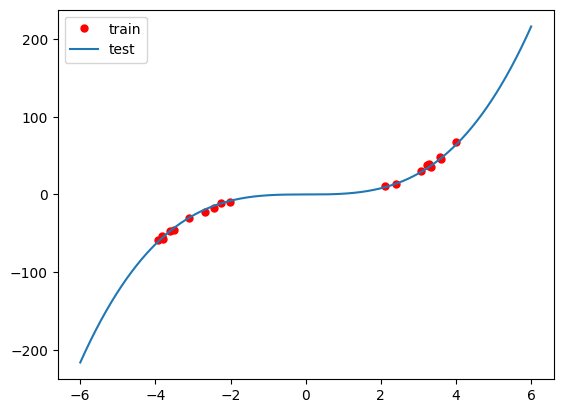

In [2]:
NUM_TRAIN_POINTS = 20
NUM_TEST_POINTS = 10000
std = 3
a1,a2,b1,b2 = -4,-2,2,4
c1,c2 = -6,6
eps = torch.randn((NUM_TRAIN_POINTS),1)*std
train_x = torch.cat((
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (a2-a1) + a1,
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (b2-b1) + b1
),dim=0)
train_y = torch.pow(train_x,3) + eps

train_y_std = train_y.std()
train_y_mean = train_y.mean()

test_x = torch.linspace(c1,c2,NUM_TEST_POINTS).reshape(-1,1)
test_y = torch.pow(test_x,3).reshape(-1,1)

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),label='test')
plt.legend()
plt.show()

In [3]:
class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
toy_train_loader = DataLoader(toy_dataset(train_x,train_y),NUM_TRAIN_POINTS)
toy_test_loader = DataLoader(toy_dataset(test_x,test_y),NUM_TEST_POINTS)

Using cpu device


  3%|▎         | 302/10000 [00:00<00:03, 3006.68it/s]

Train loss = 1572.4418321181524


 15%|█▍        | 1497/10000 [00:00<00:02, 3690.78it/s]

Train loss = 107.33579891769064


 26%|██▌       | 2617/10000 [00:00<00:01, 3698.07it/s]

Train loss = 83.51390275338314


 38%|███▊      | 3812/10000 [00:01<00:01, 3760.85it/s]

Train loss = 44.83746472987298


 46%|████▌     | 4576/10000 [00:01<00:01, 3785.52it/s]

Train loss = 15.755049388339234


 58%|█████▊    | 5771/10000 [00:01<00:01, 3792.69it/s]

Train loss = 6.953285177824762


 66%|██████▌   | 6578/10000 [00:01<00:00, 3760.91it/s]

Train loss = 5.08873887361029


 77%|███████▋  | 7739/10000 [00:02<00:00, 3811.03it/s]

Train loss = 4.10360354753586


 85%|████████▌ | 8501/10000 [00:02<00:00, 3770.89it/s]

Train loss = 3.460913521800748


 97%|█████████▋| 9676/10000 [00:02<00:00, 3779.23it/s]

Train loss = 3.0997887614810944


100%|██████████| 10000/10000 [00:02<00:00, 3748.94it/s]

Done!


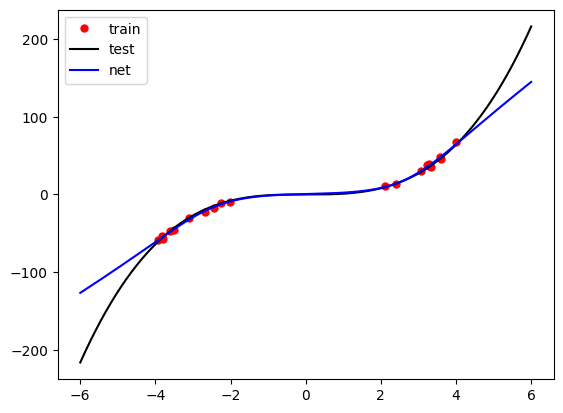

In [4]:
# Get cpu, gpu or mps device for training.
import utils.training


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## Set up neural network.
width = 50

class oneLayerMLP(torch.nn.Module):
    def __init__(self, width):
        super().__init__()
        self.output_size = 1
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, width),
            torch.nn.SiLU(),
            torch.nn.Linear(width, 1)
        )

    def forward(self, x):
        output = self.net(x)
        return output
    

## MSE Model
map_net = oneLayerMLP(width).to(device)
map_net.apply(utils.training.weights_init_ff)

map_epochs = 10000
map_lr = 0.001
map_wd = 0

mse_loss = torch.nn.MSELoss()
optimizer_MSE = torch.optim.Adam(map_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

## Training loop
def train(X, y, model, loss_fn, optimizer, scheduler):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return loss.item()

def test(X, y, model, loss_fn):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    return loss.item()

train_MSE = True
if train_MSE:
    for t in tqdm(range(map_epochs)):
        train_loss = train(train_x, train_y, map_net, mse_loss, optimizer_MSE, scheduler_MSE)
        if t % (map_epochs / 10) == 0:
            print("Train loss = {}".format(train_loss))
    print("Done!")

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),'k',label='test')
plt.plot(test_x.cpu().numpy().reshape(-1), map_net(test_x).detach().cpu().numpy().reshape(-1), 'b', label='net')
plt.legend()
plt.show()

In [5]:
## NUQLS
reload(nuqls)

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuql_test_preds, res = nuqls.series_method(map_net, train_data, test_data, ood_test_data=None, 
                                             regression= 'True', train_bs = 100, test_bs = 100, 
                                             S = 10, scale=5, lr=1e-3, epochs=1000, mu=0.9, 
                                             verbose=False)
nuql_mu = nuql_test_preds.mean(0)
nuql_var = nuql_test_preds.var(0)
print(res)

c:\Users\s4531973\Documents\PhD\Code\nuqls\posteriors\nuqls.py:226: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional_with_buffers` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params, buffers = make_functional_with_buffers(net)
100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

{'loss': tensor(3.4350, grad_fn=<DivBackward0>), 'acc': 0}


In [6]:
## DE - Heteroskedastic Variance
WIDTH = width

def to_np(x):
    return x.cpu().detach().numpy()

class EnsembleNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(1,WIDTH)
        self.relu = torch.nn.SiLU()
        self.linear_mu = torch.nn.Linear(WIDTH,1)
        self.linear_sig = torch.nn.Linear(WIDTH,1)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        mu = self.linear_mu(x)
        variance = self.linear_sig(x)
        variance = torch.nn.functional.softplus(variance) + 1e-6
        return mu, variance

class CustomNLL(torch.nn.Module):
    def __init__(self):
        super(CustomNLL, self).__init__()

    def forward(self, y, mean, var):
        
        loss = (0.5*torch.log(var) + 0.5*(y - mean).pow(2)/var).mean() + 1

        if np.any(np.isnan(to_np(loss))):
            print(torch.log(var))
            print((y - mean).pow(2)/var)
            raise ValueError('There is Nan in loss')
        
        return loss

S = 10
de_lr = 0.05
de_epochs = 2000
de_wd = 0

model_list = []
opt_list = []
sched_list = []

for i in range(S):
    model_list.append(EnsembleNetwork().to(device))
    model_list[i].apply(utils.training.weights_init_ff)
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = de_lr, weight_decay=de_wd))
    sched_list.append(torch.optim.lr_scheduler.PolynomialLR(opt_list[i], de_epochs, 0.5))

NLL = CustomNLL()

def train_heteroskedastic(X,y,net,loss,optim,sched):
    # Compute prediction error
    pred, var = net(X)
    loss = loss(y, pred, var)

    # Backpropagation
    loss.backward()

    optim.step()
    # sched.step()
    optim.zero_grad()

    return loss.item()

train_ensembles = True
if train_ensembles:
    for i in range(S):
        print("\nTraining model {}".format(i))
        for t in range(de_epochs):
            train_loss = train_heteroskedastic(train_x, train_y, model_list[i], NLL, opt_list[i], sched_list[i])
            if t % (de_epochs / 10) == 0:
                print("NLL loss = {}".format(train_loss))
                test_pred,test_var = model_list[i](train_x)
                mle_loss = mse_loss(test_pred,train_y)
                print("MSE loss = {}".format(mle_loss))
        print("Done!")

ensemble_het_mu = torch.empty((S,NUM_TEST_POINTS))
ensemble_het_var = torch.empty((S,NUM_TEST_POINTS))
for i in range(S):
    mu, var = model_list[i](test_x)
    ensemble_het_mu[i,:] = mu.reshape(1,-1)
    ensemble_het_var[i,:] = var.reshape(1,-1)
ensemble_het_mu_mean = torch.mean(ensemble_het_mu,dim=0)
ensemble_het_var_mean = torch.mean(ensemble_het_var + torch.square(ensemble_het_mu), dim=0) - torch.square(ensemble_het_mu_mean)


Training model 0
NLL loss = 925.1060009533448
MSE loss = 1521.520600624124
NLL loss = 4.685648291536355
MSE loss = 116.56515682331857
NLL loss = 3.6423173694800646
MSE loss = 62.47402025548388
NLL loss = 3.104153946557736
MSE loss = 31.817690697661515
NLL loss = 2.670313795318531
MSE loss = 14.268367101398846
NLL loss = 2.5187967045310704
MSE loss = 7.972501677083692
NLL loss = 2.4575049698359535
MSE loss = 6.17948973351816
NLL loss = 2.384947906263153
MSE loss = 4.837139512268218
NLL loss = 2.3101209189856924
MSE loss = 3.8061507488314623
NLL loss = 2.1064543297835048
MSE loss = 3.0666124655351013
Done!

Training model 1
NLL loss = 3465.2004209357938
MSE loss = 1494.3371441308877
NLL loss = 5.797719793658352
MSE loss = 118.39181773188898
NLL loss = 5.119504686735539
MSE loss = 111.21523323122385
NLL loss = 4.684868212664144
MSE loss = 105.60187468072426
NLL loss = 4.391465182367519
MSE loss = 100.431163716132
NLL loss = 4.176590238915152
MSE loss = 94.86761905843198
NLL loss = 4.0012

In [7]:
## SWAG
reload(swag)

swag_net = oneLayerMLP(width).to(device)
swag_net.apply(utils.training.weights_init_ff)

optimizer_MSE = torch.optim.Adam(swag_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

for t in tqdm(range(map_epochs)):
    train_loss = train(train_x, train_y, swag_net, mse_loss, optimizer_MSE, scheduler_MSE)
    if t % (map_epochs / 10) == 0:
        print("Train loss = {}".format(train_loss))
print("Done!")

swag_method = swag.SWAG_R(swag_net,epochs = map_epochs, lr = map_lr, cov_mat = True,
                            max_num_models=10)
swag_method.train_swag(train_x,train_y)

T = 1000
swag_pred_samples = torch.empty((T,NUM_TEST_POINTS),device='cpu')
for t in range(T):
    swag_method.sample(cov=True)
    swag_pred_samples[t,:] = swag_method(test_x).reshape(-1)
swag_pred = swag_pred_samples.mean(axis=0)
swag_var = swag_pred_samples.var(axis=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

Train loss = 1561.9057202304334


 16%|█▌        | 1613/10000 [00:00<00:02, 3873.33it/s]

Train loss = 109.86522133837077


 24%|██▍       | 2441/10000 [00:00<00:01, 3887.78it/s]

Train loss = 78.92731468462907


 33%|███▎      | 3289/10000 [00:00<00:01, 3888.52it/s]

Train loss = 43.33762612046003


 45%|████▌     | 4525/10000 [00:01<00:01, 3839.10it/s]

Train loss = 17.950760526167823


 57%|█████▋    | 5689/10000 [00:01<00:01, 3756.91it/s]

Train loss = 7.983017621980349


 65%|██████▍   | 6499/10000 [00:01<00:00, 3778.94it/s]

Train loss = 5.803392125726688


 77%|███████▋  | 7681/10000 [00:02<00:00, 3856.81it/s]

Train loss = 4.786865928643323


 85%|████████▍ | 8453/10000 [00:02<00:00, 3827.48it/s]

Train loss = 3.974778944738515


 96%|█████████▌| 9602/10000 [00:02<00:00, 3705.10it/s]

Train loss = 3.4467084596232462


100%|██████████| 10000/10000 [00:02<00:00, 3820.64it/s]


Done!


In [8]:
## LLA
from posteriors.lla.likelihoods import GaussianLh
from posteriors.lla.laplace import Laplace

prior_prec = 0.1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LLA
mu_glm_full, var_glm_full = get_pred_for('glm', 'full')



c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.oneLayerMLP'> although the module has parameters
  warnings.warn(


In [9]:
## LA
prior_prec = 1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LA
mu_bnn_full, var_bnn_full = get_pred_for('bnn', 'full')

In [10]:
# VI
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from copy import deepcopy

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 3.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 1,
}

vi_net = deepcopy(map_net)
    
dnn_to_bnn(vi_net, const_bnn_prior_parameters)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vi_net.parameters(), 1e-3, weight_decay=0)

for _ in range(10000):
    output = vi_net(train_x)
    kl = get_kl_loss(vi_net)
    ce_loss = criterion(output, train_y)
    loss = ce_loss + kl

    loss.backward()
    optimizer.step()
    print(f"loss = {loss}")

vi_net.eval()
with torch.no_grad():
    output_mc = []
    for mc_run in range(1000):
        output = vi_net(test_x)
        output_mc.append(output)
    output = torch.stack(output_mc)  
    mu_vi = output.mean(0)
    var_vi = output.var(0)


loss = 1608.7015879375522
loss = 1587.1447070031031
loss = 1589.210595781637
loss = 1598.4647718140864
loss = 1605.4812249450792
loss = 1603.5144372781729
loss = 1598.9133431950358
loss = 1592.5427931436986
loss = 1585.122603317547
loss = 1585.7448920044358
loss = 1586.9528936233112
loss = 1593.2476201973564
loss = 1586.8404922138511
loss = 1601.7795596318877
loss = 1582.4092434041295
loss = 1577.1202621789253
loss = 1580.0047595146368
loss = 1590.6084519994458
loss = 1574.480233539415
loss = 1573.6201229871742
loss = 1580.4227218471294
loss = 1579.1607245428384
loss = 1571.2946183436977
loss = 1578.203304698706
loss = 1573.0322238483031
loss = 1565.727393100771
loss = 1582.3529623463673
loss = 1566.8310156125015
loss = 1571.5548037258793
loss = 1561.2804464474282
loss = 1560.3306209081557
loss = 1572.620572255202
loss = 1563.8671957062659
loss = 1560.2853616011225
loss = 1567.0224541989091
loss = 1561.5022239956422
loss = 1554.7548020745105
loss = 1562.3376572935233
loss = 1543.246626

In [11]:
## Plot
def plot_torch(x):
    return x.detach().cpu().numpy().reshape(-1)

def plot_bayes_method(ax,mean,var,title,fs,ms,lw, legend_true=False):
    ax.plot(plot_torch(train_x),plot_torch(train_y),'ro',markersize=ms, label='Training data')
    ax.plot(plot_torch(test_x),plot_torch(test_y),'k',linewidth=lw, label='Target curve')
    ax.plot(plot_torch(test_x),plot_torch(mean),'b',linewidth=lw, label='Mean prediction')

    ci = torch.sqrt(var)*3
    y1, y2 = mean - ci, mean + ci

    ax.fill_between(plot_torch(test_x), plot_torch(y1), plot_torch(y2), color='g', alpha=.4, label='$3\sigma$')

    ax.set_title(title, fontsize=fs)
    ax.set_yticks(np.array((-200,0,200)))
    ax.set_ylim([-300,300])
    ax.tick_params(axis='both', which='major', labelsize=fs)

    if legend_true:
        ax.legend()


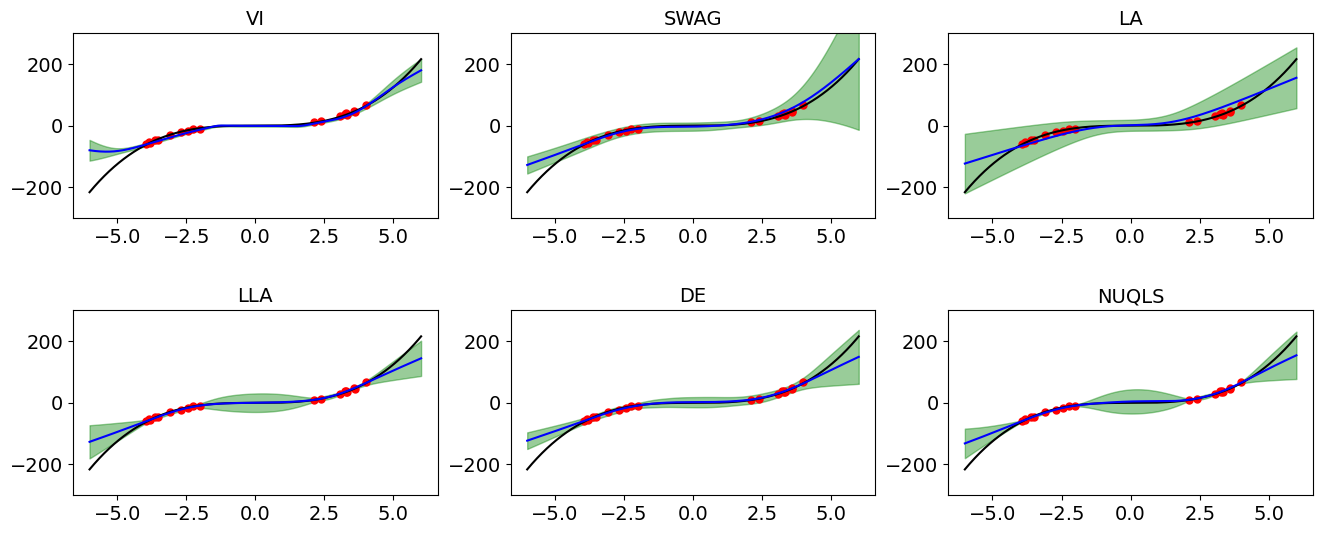

In [12]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

f.set_figheight(6)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot VI
plot_bayes_method(ax1,mu_vi,var_vi,'VI',fs=fs, ms=ms, lw=lw)

## Plot SWAG
plot_bayes_method(ax2,swag_pred,swag_var,'SWAG',fs=fs, ms=ms, lw=lw)

## LA
plot_bayes_method(ax3,mu_bnn_full,var_bnn_full,'LA',fs=fs, ms=ms, lw=lw)

## Plot LLA
plot_bayes_method(ax4,mu_glm_full,var_glm_full,'LLA',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax5,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax6,nuql_mu,nuql_var,'NUQLS',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [94]:
# BDE
from functorch import make_functional
from torch.func import vmap, jacrev

def l_layer_params(net):
    theta_star_k = []
    sd = net.state_dict()
    sdk = sd.keys()
    print(len(sdk))
    for i,p in enumerate(sdk):
        if i < len(sdk) - 2:
            theta_star_k.append(sd[p].flatten(0))
        else:
            theta_star_k.append(torch.zeros(sd[p].flatten(0).shape))
    theta_star_k = torch.cat(theta_star_k)
    return theta_star_k

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

M = 10
learning_rate = 0.01
epochs = 10000
weight_decay = 0
sigma2 = std**2

model_list = []
opt_list = []
sched_list = []

loss = mse_loss
bde_preds = torch.empty((M,NUM_TEST_POINTS))

def train_bde(X,y,net,delta,theta_k,loss,Lambda,optim,sched):
    # Compute prediction error
    pred = net(X)

    # Add delta function to outputs
    pred = pred + delta

    # Calculate loss
    loss = loss(y, pred)

    # Regularisation
    theta_t = torch.nn.utils.parameters_to_vector(net.parameters())
    diff = theta_t - theta_k
    reg = diff @ (Lambda * diff)
    loss = 0.5 * loss + 0.5 * reg

    # Backpropagation
    loss.backward()

    optim.step()
    if sched is not None:
        sched.step()
    optim.zero_grad()

    return loss.item()

def bde_weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.normal_(m.bias,mean=0,std=1)

for i in range(M):
    bde_model1 = oneLayerMLP(width).to(device)
    bde_model1.apply(bde_weights_init)
    opt = torch.optim.Adam(bde_model1.parameters(), lr = map_lr, weight_decay=map_wd)
    sched = torch.optim.lr_scheduler.PolynomialLR(opt, map_epochs, 0.5)

    ## Find theta~
    bde_model2 = oneLayerMLP(width).to(device)
    bde_model2.apply(utils.training.weights_init_ff) 
    theta_star_k = l_layer_params(bde_model2)

    ## Create delta functions
    fnet, params = make_functional(bde_model1)
    def jacobian(x):
        def fnet_single(params, x):
            return fnet(params, x.unsqueeze(0)).squeeze(0)
        J = vmap(jacrev(fnet_single), (None, 0))(params, x.to(device))
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J
    delta = lambda x : jacobian(x) @ theta_star_k
    train_delta = delta(train_x)

    ## Save theta_k
    theta_k = torch.nn.utils.parameters_to_vector(bde_model1.parameters()).detach().clone()

    ## Create Mahalanobis matrix
    Lambda = 1 / sigma2

    ## Train ensemble member
    print("\nTraining model {}".format(i))
    for t in tqdm(range(map_epochs)):
        train_loss = train_bde(train_x, train_y, bde_model1, train_delta, theta_k, mse_loss, Lambda, opt, sched)
        if t % (epochs / 10) == 0:
            print("train loss = {:.4f}".format(train_loss))
    print("Done!")

    # Get predictions
    bde_pred = bde_model1(test_x).reshape(-1) + delta(test_x).reshape(-1)
    bde_preds[i,:] = bde_pred

bde_mean = torch.mean(bde_preds,dim=0)
bde_var = torch.var(bde_preds,dim=0)  + std**2

C:\Users\s4531973\AppData\Local\Temp\ipykernel_13368\260022551.py:77: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(bde_model1)


4

Training model 0


  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([20, 20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 228/10000 [00:00<00:04, 2261.07it/s]

train loss = 733.6074


 12%|█▏        | 1227/10000 [00:00<00:03, 2397.03it/s]

train loss = 59.1979


 22%|██▏       | 2210/10000 [00:00<00:03, 2308.87it/s]

train loss = 41.4790


 32%|███▏      | 3220/10000 [00:01<00:02, 2383.84it/s]

train loss = 30.7702


 45%|████▍     | 4489/10000 [00:01<00:02, 2449.80it/s]

train loss = 22.8878


 53%|█████▎    | 5256/10000 [00:02<00:01, 2431.88it/s]

train loss = 17.4736


 63%|██████▎   | 6308/10000 [00:02<00:01, 2434.20it/s]

train loss = 15.0756


 73%|███████▎  | 7326/10000 [00:03<00:01, 2451.43it/s]

train loss = 14.2445


 83%|████████▎ | 8340/10000 [00:03<00:00, 2439.85it/s]

train loss = 13.8810


 93%|█████████▎| 9336/10000 [00:03<00:00, 2415.19it/s]

train loss = 13.7127


100%|██████████| 10000/10000 [00:04<00:00, 2408.77it/s]


Done!
4

Training model 1


  3%|▎         | 265/10000 [00:00<00:04, 2341.07it/s]

train loss = 726.2131


 15%|█▌        | 1529/10000 [00:00<00:03, 2448.72it/s]

train loss = 58.9464


 23%|██▎       | 2265/10000 [00:00<00:03, 2447.34it/s]

train loss = 42.1273


 33%|███▎      | 3283/10000 [00:01<00:02, 2446.17it/s]

train loss = 27.2073


 43%|████▎     | 4268/10000 [00:01<00:02, 2454.01it/s]

train loss = 17.7041


 53%|█████▎    | 5270/10000 [00:02<00:01, 2428.59it/s]

train loss = 13.5454


 63%|██████▎   | 6293/10000 [00:02<00:01, 2449.28it/s]

train loss = 12.6212


 73%|███████▎  | 7318/10000 [00:03<00:01, 2370.91it/s]

train loss = 12.4122


 83%|████████▎ | 8328/10000 [00:03<00:00, 2419.18it/s]

train loss = 12.2904


 93%|█████████▎| 9303/10000 [00:03<00:00, 2426.23it/s]

train loss = 12.1942


100%|██████████| 10000/10000 [00:04<00:00, 2428.63it/s]


Done!
4

Training model 2


  2%|▎         | 250/10000 [00:00<00:04, 2176.96it/s]

train loss = 715.4203


 15%|█▍        | 1469/10000 [00:00<00:03, 2424.02it/s]

train loss = 61.5049


 22%|██▏       | 2241/10000 [00:00<00:03, 2434.13it/s]

train loss = 47.6562


 33%|███▎      | 3255/10000 [00:01<00:02, 2435.62it/s]

train loss = 30.7569


 45%|████▍     | 4486/10000 [00:01<00:02, 2459.07it/s]

train loss = 18.2300


 53%|█████▎    | 5257/10000 [00:02<00:01, 2443.65it/s]

train loss = 14.0261


 65%|██████▍   | 6482/10000 [00:02<00:01, 2406.30it/s]

train loss = 13.2714


 73%|███████▎  | 7253/10000 [00:03<00:01, 2431.28it/s]

train loss = 13.0397


 83%|████████▎ | 8270/10000 [00:03<00:00, 2437.66it/s]

train loss = 12.9014


 93%|█████████▎| 9284/10000 [00:03<00:00, 2439.09it/s]

train loss = 12.7996


100%|██████████| 10000/10000 [00:04<00:00, 2427.23it/s]


Done!
4

Training model 3


  2%|▏         | 202/10000 [00:00<00:04, 2018.88it/s]

train loss = 690.8310


 12%|█▏        | 1215/10000 [00:00<00:03, 2399.69it/s]

train loss = 63.9388


 22%|██▏       | 2237/10000 [00:00<00:03, 2445.03it/s]

train loss = 45.5337


 33%|███▎      | 3296/10000 [00:01<00:02, 2445.43it/s]

train loss = 30.5752


 43%|████▎     | 4341/10000 [00:01<00:02, 2437.38it/s]

train loss = 20.9453


 54%|█████▍    | 5398/10000 [00:02<00:01, 2451.56it/s]

train loss = 15.7543


 64%|██████▍   | 6413/10000 [00:02<00:01, 2435.89it/s]

train loss = 14.0361


 72%|███████▏  | 7182/10000 [00:02<00:01, 2439.82it/s]

train loss = 13.6227


 82%|████████▏ | 8203/10000 [00:03<00:00, 2438.51it/s]

train loss = 13.4501


 95%|█████████▍| 9457/10000 [00:03<00:00, 2431.14it/s]

train loss = 13.3498


100%|██████████| 10000/10000 [00:04<00:00, 2427.32it/s]


Done!
4

Training model 4


  3%|▎         | 263/10000 [00:00<00:04, 2337.20it/s]

train loss = 713.3795


 12%|█▏        | 1239/10000 [00:00<00:03, 2433.38it/s]

train loss = 58.6573


 23%|██▎       | 2263/10000 [00:00<00:03, 2436.53it/s]

train loss = 48.4476


 33%|███▎      | 3292/10000 [00:01<00:02, 2410.58it/s]

train loss = 37.2002


 43%|████▎     | 4302/10000 [00:01<00:02, 2425.83it/s]

train loss = 25.7716


 53%|█████▎    | 5308/10000 [00:02<00:01, 2433.40it/s]

train loss = 17.8832


 63%|██████▎   | 6300/10000 [00:02<00:01, 2445.96it/s]

train loss = 14.1657


 73%|███████▎  | 7347/10000 [00:03<00:01, 2456.33it/s]

train loss = 13.4110


 84%|████████▎ | 8359/10000 [00:03<00:00, 2433.96it/s]

train loss = 13.1589


 94%|█████████▍| 9376/10000 [00:03<00:00, 2447.76it/s]

train loss = 13.0060


100%|██████████| 10000/10000 [00:04<00:00, 2423.23it/s]


Done!
4

Training model 5


  3%|▎         | 253/10000 [00:00<00:04, 2203.37it/s]

train loss = 713.8386


 12%|█▏        | 1222/10000 [00:00<00:03, 2398.55it/s]

train loss = 66.5418


 23%|██▎       | 2287/10000 [00:00<00:03, 2448.61it/s]

train loss = 54.3763


 33%|███▎      | 3279/10000 [00:01<00:02, 2395.70it/s]

train loss = 36.4095


 43%|████▎     | 4251/10000 [00:01<00:02, 2418.56it/s]

train loss = 23.2540


 53%|█████▎    | 5300/10000 [00:02<00:01, 2422.69it/s]

train loss = 15.9960


 63%|██████▎   | 6311/10000 [00:02<00:01, 2417.90it/s]

train loss = 14.2901


 73%|███████▎  | 7308/10000 [00:03<00:01, 2409.88it/s]

train loss = 13.8677


 83%|████████▎ | 8316/10000 [00:03<00:00, 2414.73it/s]

train loss = 13.6277


 93%|█████████▎| 9321/10000 [00:03<00:00, 2418.60it/s]

train loss = 13.4734


100%|██████████| 10000/10000 [00:04<00:00, 2417.48it/s]


Done!
4

Training model 6


  2%|▏         | 202/10000 [00:00<00:04, 2016.67it/s]

train loss = 701.5567


 15%|█▍        | 1458/10000 [00:00<00:03, 2434.53it/s]

train loss = 58.8269


 22%|██▏       | 2202/10000 [00:00<00:03, 2399.58it/s]

train loss = 43.1550


 34%|███▍      | 3441/10000 [00:01<00:02, 2407.82it/s]

train loss = 28.5466


 44%|████▍     | 4424/10000 [00:01<00:02, 2434.16it/s]

train loss = 19.3537


 54%|█████▍    | 5400/10000 [00:02<00:01, 2426.05it/s]

train loss = 14.3260


 64%|██████▍   | 6376/10000 [00:02<00:01, 2431.82it/s]

train loss = 12.6680


 74%|███████▍  | 7407/10000 [00:03<00:01, 2436.43it/s]

train loss = 12.2970


 84%|████████▍ | 8420/10000 [00:03<00:00, 2432.82it/s]

train loss = 12.1598


 94%|█████████▍| 9431/10000 [00:03<00:00, 2433.35it/s]

train loss = 12.0740


100%|██████████| 10000/10000 [00:04<00:00, 2406.12it/s]


Done!
4

Training model 7


  3%|▎         | 270/10000 [00:00<00:03, 2447.41it/s]

train loss = 715.2995


 13%|█▎        | 1267/10000 [00:00<00:03, 2415.08it/s]

train loss = 56.8198


 23%|██▎       | 2283/10000 [00:00<00:03, 2432.91it/s]

train loss = 42.9292


 33%|███▎      | 3298/10000 [00:01<00:02, 2436.30it/s]

train loss = 26.8948


 43%|████▎     | 4320/10000 [00:01<00:02, 2452.03it/s]

train loss = 16.7497


 53%|█████▎    | 5337/10000 [00:02<00:01, 2449.93it/s]

train loss = 13.3493


 63%|██████▎   | 6338/10000 [00:02<00:01, 2421.16it/s]

train loss = 12.6417


 73%|███████▎  | 7349/10000 [00:03<00:01, 2434.35it/s]

train loss = 12.4173


 84%|████████▍ | 8400/10000 [00:03<00:00, 2441.48it/s]

train loss = 12.2796


 94%|█████████▍| 9422/10000 [00:03<00:00, 2457.58it/s]

train loss = 12.1623


100%|██████████| 10000/10000 [00:04<00:00, 2417.06it/s]


Done!
4

Training model 8


  2%|▏         | 227/10000 [00:00<00:04, 2267.40it/s]

train loss = 741.0744


 12%|█▏        | 1243/10000 [00:00<00:03, 2427.01it/s]

train loss = 59.4154


 23%|██▎       | 2271/10000 [00:00<00:03, 2464.56it/s]

train loss = 43.6682


 33%|███▎      | 3261/10000 [00:01<00:02, 2465.56it/s]

train loss = 30.2861


 43%|████▎     | 4308/10000 [00:01<00:02, 2443.72it/s]

train loss = 21.5100


 54%|█████▎    | 5360/10000 [00:02<00:01, 2448.97it/s]

train loss = 16.1787


 63%|██████▎   | 6338/10000 [00:02<00:01, 2440.19it/s]

train loss = 14.3114


 74%|███████▎  | 7351/10000 [00:03<00:01, 2444.07it/s]

train loss = 13.8494


 84%|████████▎ | 8365/10000 [00:03<00:00, 2434.89it/s]

train loss = 13.6606


 94%|█████████▎| 9374/10000 [00:03<00:00, 2437.47it/s]

train loss = 13.5326


100%|██████████| 10000/10000 [00:04<00:00, 2431.62it/s]


Done!
4

Training model 9


  3%|▎         | 251/10000 [00:00<00:04, 2171.35it/s]

train loss = 717.1692


 13%|█▎        | 1264/10000 [00:00<00:03, 2415.04it/s]

train loss = 59.2724


 23%|██▎       | 2285/10000 [00:00<00:03, 2442.34it/s]

train loss = 46.0173


 33%|███▎      | 3301/10000 [00:01<00:02, 2437.42it/s]

train loss = 31.3893


 43%|████▎     | 4278/10000 [00:01<00:02, 2434.50it/s]

train loss = 20.4982


 53%|█████▎    | 5257/10000 [00:02<00:01, 2425.45it/s]

train loss = 15.1663


 65%|██████▍   | 6482/10000 [00:02<00:01, 2446.24it/s]

train loss = 13.7500


 75%|███████▍  | 7461/10000 [00:03<00:01, 2434.00it/s]

train loss = 13.4341


 85%|████████▍ | 8460/10000 [00:03<00:00, 2409.39it/s]

train loss = 13.2721


 92%|█████████▏| 9223/10000 [00:03<00:00, 2408.76it/s]

train loss = 13.1620


100%|██████████| 10000/10000 [00:04<00:00, 2417.38it/s]

Done!


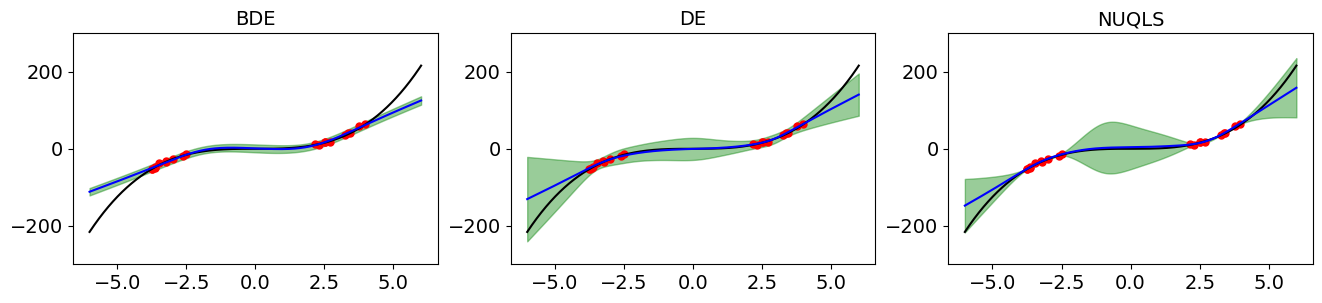

In [96]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, (ax1,ax2,ax3) = plt.subplots(1,3)

f.set_figheight(3)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot BDE
plot_bayes_method(ax1,bde_mean,bde_var,'BDE',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax2,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax3,nuql_mu,nuql_var,'NUQLS',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison_bde.pdf", format="pdf", bbox_inches="tight")
plt.show()